In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)


# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# estudo SVM
from sklearn.svm import SVC

from joblib import dump

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS, MODELO_FINAL
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [3]:
df = pd.read_parquet(DADOS_TRATADOS)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna  not in (colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo)
]

In [5]:
colunas_numericas_min_max = [
    "DailyRate",
    "MonthlyRate"]

colunas_numericas_std = ["Age"]

coluns_numericas_power_transform = [
    coluna for coluna in colunas_numericas if coluna not in (
        colunas_numericas_min_max + colunas_numericas_std
    )
]

coluns_numericas_power_transform

['DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
preprocessamento_arvore = ColumnTransformer(
    transformers = [
        ("one_hot", OneHotEncoder(drop="first"), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_categoricas_ordenadas)
    ]
)

preprocessamento = ColumnTransformer(
    transformers = [
        ("one_hot", OneHotEncoder(drop="first"), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_categoricas_ordenadas),
        ("min_max", MinMaxScaler(), colunas_numericas_min_max),
        ("stdscaler", StandardScaler(), colunas_numericas_std),
        ("power_tranform", PowerTransformer(), coluns_numericas_power_transform)
    ]
)

In [10]:
todas_colunas = (
    colunas_categoricas_nao_ordenadas +
    colunas_categoricas_ordenadas +
    colunas_numericas_min_max +
    colunas_numericas_std +
    coluns_numericas_power_transform  # nome corrigido
)

for col in todas_colunas:
    if col not in df.columns:
        print(f"❌ Coluna não encontrada no DataFrame: {col}")


In [11]:
classificadores = {
    "DummyClassifier" : {
        "preprocessor" : None,
        "classificador" : DummyClassifier(strategy = "stratified"),
    },
     "LogisticRegression" : {
        "preprocessor" : preprocessamento,
        "classificador" : LogisticRegression(class_weight="balanced"),
    },
     "DecisionTreeClassifier" : {
        "preprocessor" : preprocessamento_arvore,
        "classificador" : DecisionTreeClassifier(class_weight="balanced"),
    },
     "LGBMClassifier" : {
         "preprocessor" : preprocessamento_arvore,
          "classificador" : LGBMClassifier(
              random_state=RANDOM_STATE,
              n_jobs=-1,
              verbose=-1,
              scale_pos_weight=np.bincount(y)[0] / np.bincount(y)[1]
          ),
    },
    "XGBClassifier" : {
        "preprocessor" : preprocessamento_arvore,
        "classificador" : XGBClassifier(
          random_state=RANDOM_STATE,
          n_jobs=-1,
          scale_pos_weight=np.bincount(y)[0] / np.bincount(y)[1]
           ),
    },
    "SVC" : {
        "preprocessor" : preprocessamento,
        "classificador" : SVC(class_weight="balanced"),
    },
    "KNeighborsClassifier" : {
        "preprocessor" : preprocessamento,
        "classificador" : KNeighborsClassifier(),
    }   
}

In [12]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X,y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

C:\Users\viniv\anaconda3\envs\ml_kernel\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\viniv\anaconda3\envs\ml_kernel\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\viniv\anaconda3\envs\ml_kernel\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\viniv\anaconda3\envs\ml_kernel\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\viniv\anaconda3\envs\ml_kernel\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fit

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.000999,0.014997,0.731293,0.470528,0.091954,0.102564,0.083333,0.502033,0.163832,0.015996
1,DummyClassifier,0.001,0.007999,0.717687,0.470783,0.107527,0.111111,0.104167,0.477388,0.15836,0.008999
2,DummyClassifier,0.001,0.008001,0.755102,0.509691,0.162791,0.179487,0.148936,0.54363,0.177744,0.009001
3,DummyClassifier,0.001,0.008999,0.727891,0.50211,0.166667,0.163265,0.170213,0.52287,0.16755,0.009999
4,DummyClassifier,0.000999,0.009,0.727891,0.467654,0.090909,0.097561,0.085106,0.497545,0.159222,0.009999
5,LogisticRegression,0.211442,0.029,0.741497,0.72815,0.472222,0.354167,0.708333,0.815633,0.56248,0.240442
6,LogisticRegression,0.046,0.03,0.768707,0.752795,0.507246,0.388889,0.729167,0.836806,0.620079,0.076
7,LogisticRegression,0.049,0.031,0.758503,0.761521,0.503497,0.375,0.765957,0.838229,0.652755,0.08
8,LogisticRegression,0.047,0.029005,0.789116,0.77974,0.537313,0.413793,0.765957,0.842708,0.650979,0.076005
9,LogisticRegression,0.0475,0.029999,0.772109,0.75239,0.503704,0.386364,0.723404,0.785942,0.577877,0.077498


In [13]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.001,0.009799,0.731973,0.484153,0.123969,0.130798,0.118351,0.508693,0.165342,0.010799
DecisionTreeClassifier,0.016399,0.022001,0.791837,0.614984,0.352358,0.352743,0.354078,0.614984,0.230635,0.0384
KNeighborsClassifier,0.043205,0.085103,0.846939,0.554141,0.200693,0.613016,0.122074,0.684688,0.318985,0.128308
XGBClassifier,0.068902,0.032,0.826531,0.664686,0.441594,0.459649,0.425887,0.777781,0.468712,0.100902
LGBMClassifier,0.108605,0.0334,0.823129,0.684999,0.467428,0.454588,0.481117,0.79295,0.497247,0.142005
SVC,0.075601,0.057302,0.82585,0.758237,0.550509,0.473499,0.658422,0.83123,0.61181,0.132903
LogisticRegression,0.080188,0.029801,0.765986,0.754919,0.504796,0.383642,0.738564,0.823864,0.612834,0.109989


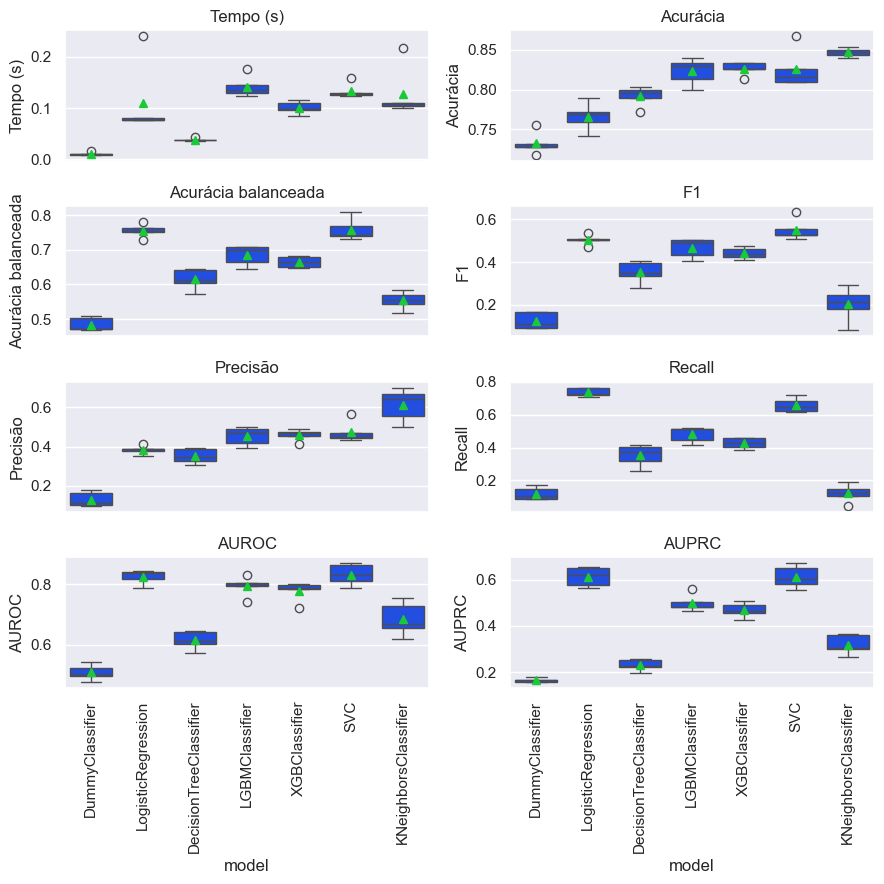

In [14]:
plot_comparar_metricas_modelos(df_resultados)

In [15]:
param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [16]:
clf = LogisticRegression(solver="saga", random_state=RANDOM_STATE, class_weight="balanced")

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento, refit_metric="average_precision",
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                                                          'YearsWithCurrManager'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [17]:
grid_search.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                                                          'YearsWithCurrManager'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [18]:
grid_search.best_params_

{'clf__C': 0.1, 'clf__l1_ratio': 0.5, 'clf__penalty': 'elasticnet'}

In [19]:
grid_search.best_score_

0.632803617381539

In [20]:
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [21]:
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.7619047619047619
mean_test_balanced_accuracy: 0.7508051119575715
mean_test_f1: 0.4993334378028441
mean_test_precision: 0.37873982000703094
mean_test_recall: 0.7343971631205675
mean_test_roc_auc: 0.8227291004712958
mean_test_average_precision: 0.632803617381539


In [22]:
coefs = dataframe_coeficientes (
    grid_search.best_estimator_["clf"].coef_[0],
    grid_search.best_estimator_["preprocessor"].get_feature_names_out()
)

coefs.query("coeficiente == 0")

,coeficiente
power_tranform__HourlyRate,0.0
min_max__MonthlyRate,0.0
ordinal__PerformanceRating,0.0
ordinal__Education,0.0
one_hot__JobRole_Human Resources,0.0
one_hot__EducationField_Marketing,0.0
one_hot__JobRole_Sales Executive,0.0
one_hot__JobRole_Research Director,0.0
one_hot__JobRole_Manufacturing Director,0.0
one_hot__JobRole_Manager,0.0


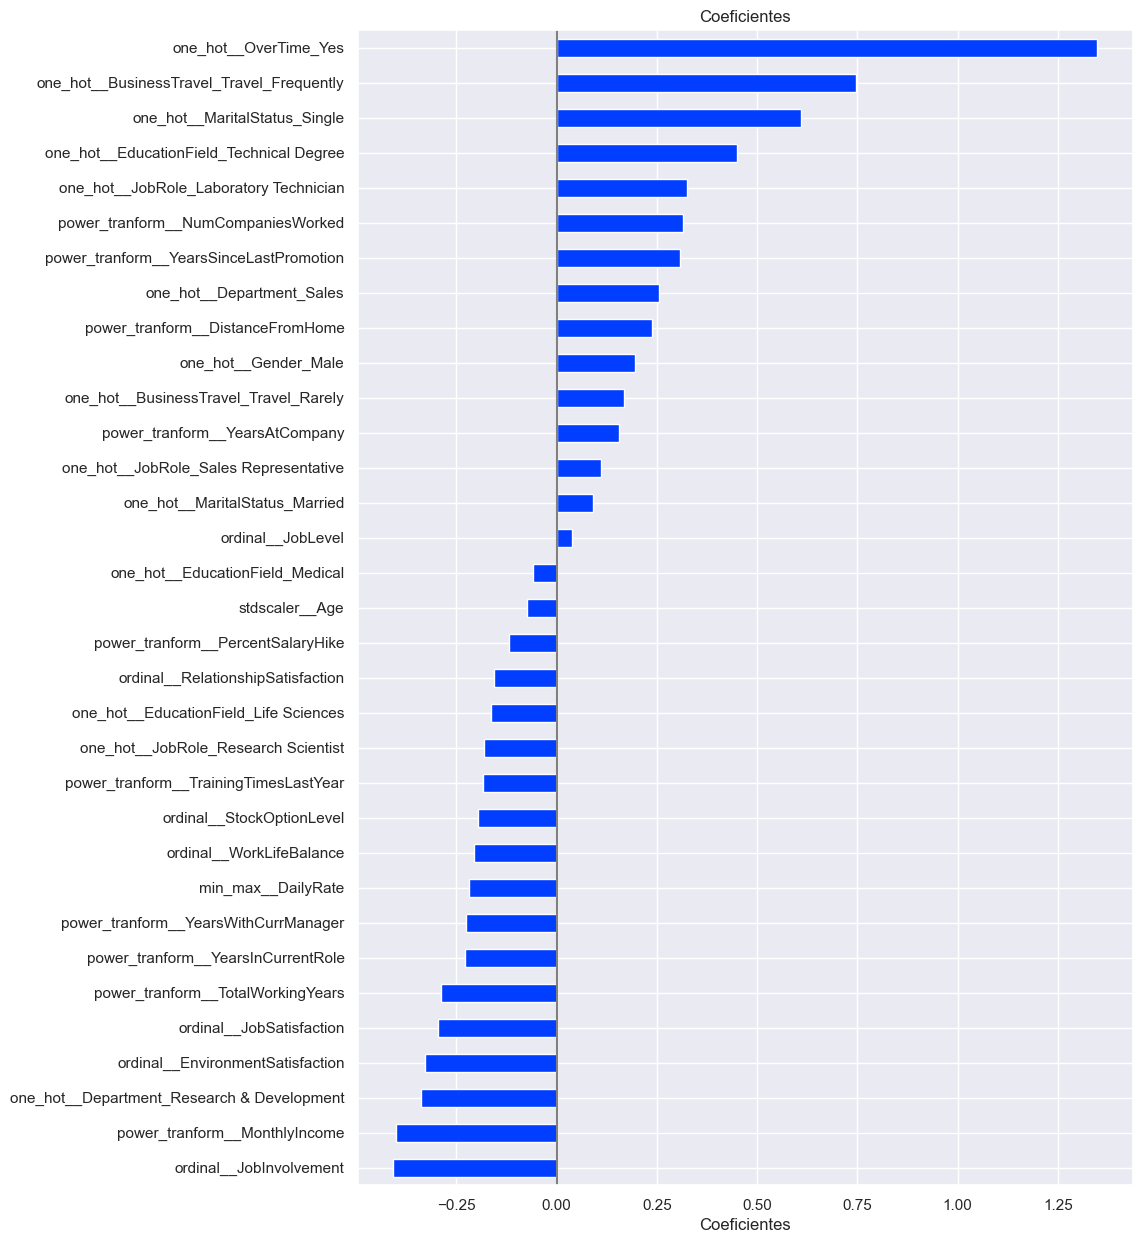

In [23]:
plot_coeficientes(coefs.query("coeficiente != 0"))

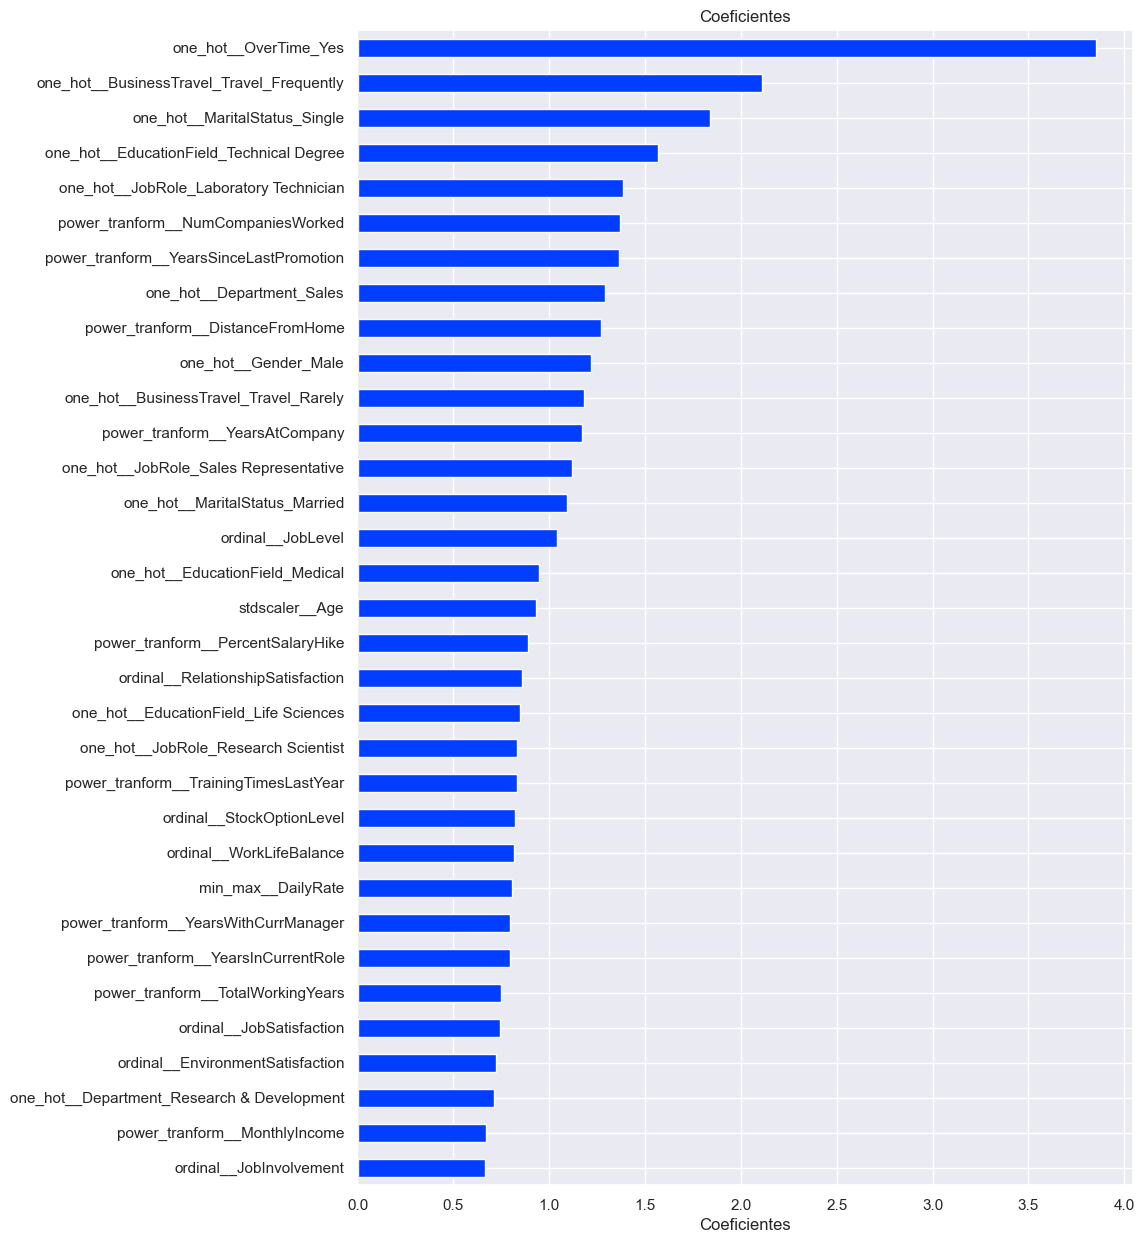

In [24]:
coefs_odds = coefs.copy()
coefs_odds["coeficiente"] = np.exp(coefs_odds["coeficiente"])

plot_coeficientes(coefs_odds.query("coeficiente != 1"))

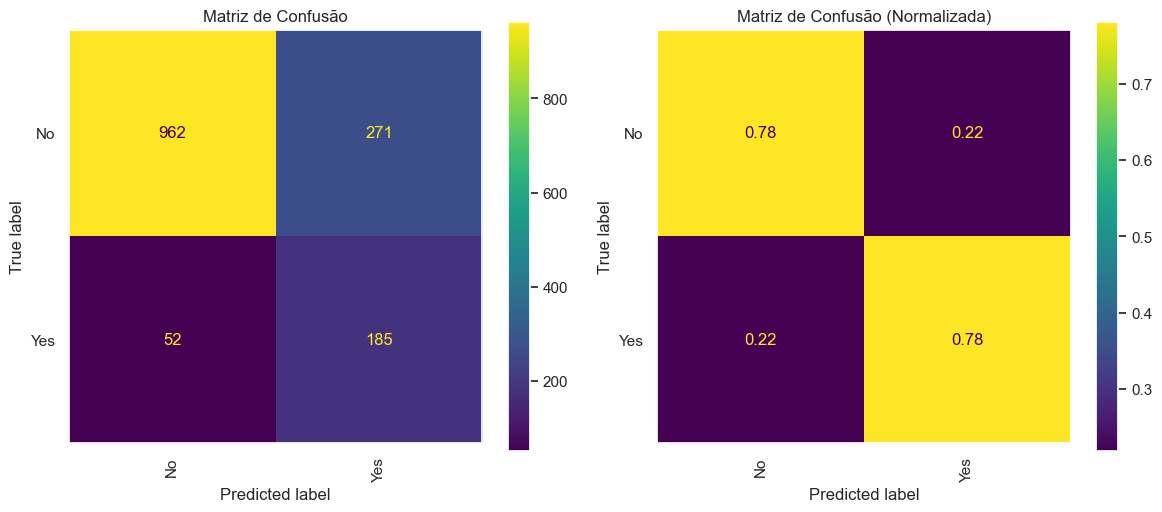

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    ax=axes[0],
    xticks_rotation='vertical'
)
axes[0].set_title("Matriz de Confusão")
axes[0].grid(False)

ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize='true',
    ax=axes[1],
    xticks_rotation='vertical'
)
axes[1].set_title("Matriz de Confusão (Normalizada)")
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [26]:
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\viniv\\Documents\\Data science\\Portifolio\\Projeto IBM attrition\\modelos\\logistic_regression.joblib']